In [ ]:
!pip install rasterio

## **[1] Importación de Librerías**



In [ ]:
# ===============================
# 1️⃣ Core Libraries
# ===============================
import os  # File and directory operations
from google.colab import files
from google.colab import drive
import numpy as np  # Numerical and array operations

# ===============================
# 2️⃣ Visualization
# ===============================
import matplotlib.pyplot as plt  # Plotting and visualization

# ===============================
# 3️⃣ Image Processing (General)
# ===============================
from PIL import Image  # For handling standard image formats (PNG, JPEG, etc.)
import cv2  # OpenCV for advanced image processing

# ===============================
# 4️⃣ TIFF and GeoTIFF Handling
# ===============================
import tifffile as tiff  # Reading/writing TIFF images
import rasterio  # Reading/writing GeoTIFFs with geospatial metadata
from rasterio.transform import from_origin
from rasterio.windows import Window  # For extracting sub-windows/tiles from GeoTIFFs

In [ ]:
def loadNir(path):
    """
    Reads a single-band NIR GeoTIFF, cleans NoData values,
    and normalizes it into [0, 1].

    Parameters:
        path (str): Path to the NIR .tif file.

    Returns:
        np.ndarray: Cleaned and normalized NIR array (H, W).
    """
    # Open the GeoTIFF file using rasterio
    with rasterio.open(path) as src:
        # Read the first (and only) band as a float32 numpy array
        nir = src.read(1, masked=True)  # Read as masked array

        # Replace any NaN values with 0.0 to clean NoData regions
        # Normalize reflectance values
        norm = np.nan_to_num(nir, nan=0.0) / np.max(nir)

        # Clip values to ensure they remain in the range [0, 1]
        norm = np.clip(norm, 0, 1)

    # Return the cleaned and normalized NIR array
    return norm

## **[2] Escalamiento de NIR**

In [ ]:
def resize(nir: np.ndarray, rgb: np.ndarray) -> np.ndarray:
    """
    Resize a single-band NIR image to match the dimensions of an RGB image.

    Parameters
    ----------
    nir : np.ndarray
        The original NIR image, assumed to be 2D (H_nir, W_nir). Can be any numeric type.
    rgb : np.ndarray
        The reference RGB image to match, assumed to be 3D (H_rgb, W_rgb, 3).

    Returns
    -------
    np.ndarray
        The resized NIR image as a 2D array (H_rgb, W_rgb), with values preserved
        as floats in the original scale.

    Notes
    -----
    - The function uses OpenCV's INTER_LINEAR interpolation for smooth scaling.
      This preserves continuous NIR values better than nearest-neighbor.
    - Avoid converting to integers before resizing to prevent loss of precision.
    - After resizing, you can normalize if needed (e.g., divide by max value or 255).
    """
    # Get target height and width from RGB image
    target_H, target_W = rgb.shape[:2]

    # Ensure NIR is float32 for proper interpolation
    nir_float = nir.astype(np.float32)

    # Resize NIR to RGB dimensions
    resized = cv2.resize(nir_float, (target_W, target_H), interpolation=cv2.INTER_LINEAR)

    return resized

In [ ]:
# Load the RGB image from the specified path.
# cv2.IMREAD_UNCHANGED ensures the image is loaded as-is (including alpha channel if present).
RGB = cv2.imread('/content/result.tif', cv2.IMREAD_UNCHANGED)

# Load the Near-Infrared (NIR) image from the specified path.
# Again, cv2.IMREAD_UNCHANGED loads the image without any modification.
NIR = loadNir('/content/result_NIR.tif')

In [ ]:
print("NIR array shape:", NIR.shape)
print("Data type:", NIR.dtype)
print("Value range:", np.nanmin(NIR), "-", np.nanmax(NIR))

NIR array shape: (12749, 6887)
Data type: float32
Value range: 0.033346105 - 1.0


In [ ]:
resized = resize(nir=NIR, rgb=RGB)
print(f"NIR resized shape: {resized.shape}")  # Should match RGB (H, W)

NIR resized shape: (21642, 11691)


## **[3] Unión de Bandas y Obtención de NDVI**

In [ ]:
def combineChannels(rgb, nir):
    """
    Combines an RGB image and a NIR (Near-Infrared) image into a single 4-channel image array.

    Parameters:
        rgb (numpy.ndarray): The input RGB image array of shape (H, W, 3), with values typically in [0, 255].
        nir (numpy.ndarray): The input NIR image array of shape (H, W), with values typically in [0, 255] or raw intensity values.

    Returns:
        numpy.ndarray: A 4-channel image array of shape (H, W, 4), where the first three channels are normalized RGB,
                       and the fourth channel is the normalized NIR.

    Notes:
        - This function normalizes RGB values to [0, 1] by dividing by 255.0.
        - The NIR channel is normalized by dividing by its maximum value to scale it to [0, 1].
        - The NIR image is expanded along the last dimension to match the shape of RGB for concatenation.
        - Assumes that both RGB and NIR images are spatially aligned (same height and width).
    """

    # Normalize RGB channels to range [0, 1]
    # Remove extra band (has no use)
    rgb_norm = rgb[..., :3] / 255.0

    # Extract Red channel
    red = rgb_norm[..., 0]

    # Compute NDVI (NDVI = (NIR - Red) / (NIR + Red))
    # Convert NIR and Red bands to float for accurate division
    denominator = (nir + red)

    # Avoid division by zero by replacing any zero in the denominator with a very small number (epsilon)
    denominator[denominator == 0] = 1e-6  # Prevents divide-by-zero errors

    # Calculate NDVI: result is in the range [-1, 1]
    ndvi = (nir - red) / denominator

    # Expand the NDVI array to add it as a 4th channel
    # Original NDVI shape: (H, W) --> Expanded shape: (H, W, 1)
    ndvi_channel = np.expand_dims(ndvi, axis=-1)

    # Concatenate normalized RGB and NDVI into a single 4-channel image
    # Resulting shape: (H, W, 4) -> [R, G, B, NDVI]
    combined = np.concatenate([rgb_norm, ndvi_channel], axis=-1)

    return combined

In [ ]:
# Call the function to combine the RGB and NIR images into a single 4-channel array.
combined = combineChannels(rgb=RGB, nir=resized)

# Print the shape of the combined image to confirm it's (H, W, 4)
print(f"Combined shape: {combined.shape}")

Combined shape: (21642, 11691, 4)


## **[4] Generación de Tiles**

In [ ]:
def generateTiles(img, size=256, stride=None, drop_last=True):
    """
    Splits a multi-channel satellite img into smaller tiles.

    Parameters:
        img (np.ndarray): Input image of shape (H, W, C), where
                            H = height, W = width, C = number of channels.
                            Example: combined RGB+NIR or RGB+NDVI image.
        size (int): Size (in pixels) of each square tile (tile_size x tile_size).
        stride (int or None): Step size for moving the tile window.
                              If None, defaults to non-overlapping tiles (i.e., stride = tile_size).
        drop_last (bool):
            - True  = Drop incomplete tiles at the edges (that don’t fully fit).
            - False = Pad the image with zeros to ensure all tiles are full-sized.

    Returns:
        tiles (list of np.ndarray): List of image tiles, each of shape (tile_size, tile_size, C).
    """

    # Get the original dimensions of the input image
    H, W, C = img.shape

    # If stride is not specified, use size for non-overlapping tiling
    if stride is None:
        stride = size

    # Initialize a list to store the resulting tiles
    tiles = []

    # Calculate required padding on bottom and right edges (if needed)
    pad_h = (size - H % size) % size  # Padding for height
    pad_w = (size - W % size) % size  # Padding for width

    # If padding is enabled (drop_last is False), pad the image with zeros
    if not drop_last and (pad_h > 0 or pad_w > 0):
        img = np.pad(
            img,
            pad_width=((0, pad_h), (0, pad_w), (0, 0)),  # Pad H, W only; not channels
            mode="constant",
            constant_values=0
        )
        # Update H and W to reflect padded size
        H, W, _ = img.shape

    # Slide the window over the img to extract tiles
    for i in range(0, H - size + 1, stride):
        for j in range(0, W - size + 1, stride):
            # Extract a tile from (i, j) position
            tile = img[i:i+size, j:j+size, :]

            # Only append full-sized tiles (safety check)
            if tile.shape[0] == size and tile.shape[1] == size:
                tiles.append(tile)

    return tiles

In [ ]:
tiles = generateTiles(combined, size=2048, stride=2048, drop_last=True)

In [ ]:
def display_tile(tile):
    """
    Displays RGB and NDVI side by side from a combined image tile.

    Parameters:
        tile (np.ndarray): Array of shape (H, W, C).
                           Assumes:
                             - First 3 channels → RGB
                             - Last channel → NDVI
    """
    rgb = np.clip(tile[:, :, :3], 0, 1)
    ndvi = tile[:, :, -1]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # RGB
    axes[0].imshow(rgb)
    axes[0].set_title("RGB Tile")
    axes[0].axis("off")

    # NDVI
    im = axes[1].imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
    axes[1].set_title("NDVI Tile")
    axes[1].axis("off")
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label="NDVI")

    plt.tight_layout()
    plt.show()

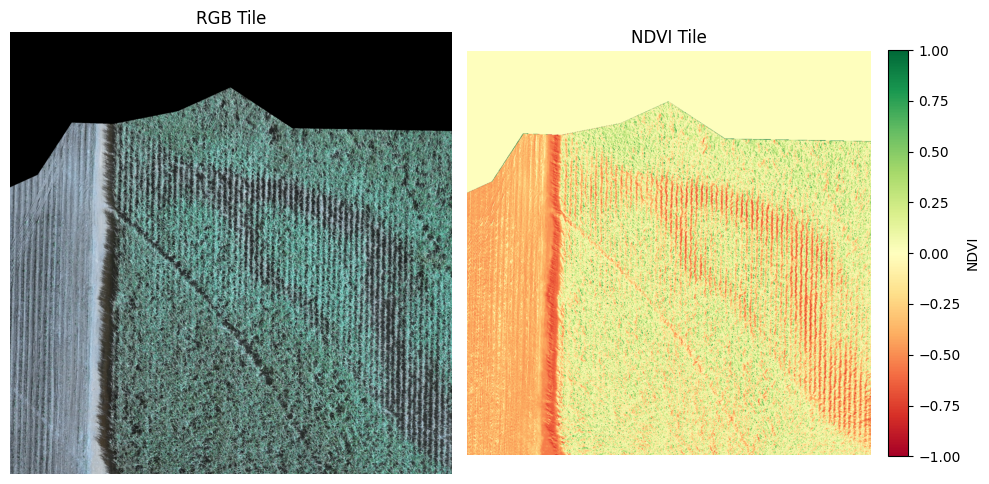

In [ ]:
# Take first tile
display_tile(tile=tiles_[1])

In [ ]:
# Define your Drive folder (replace with your path)
drive_folder = "/content/drive/MyDrive/Andreita's all for one/tiles/image_01"

# Create the folder in Drive if it doesn't exist
os.makedirs(drive_folder, exist_ok=True)

# Loop through tiles and save them
for i, tile in enumerate(tiles):  # tiles: list or array of shape (H, W, 4)
    # Convert (H, W, 4) -> (4, H, W) for rasterio
    tile_4bands = np.transpose(tile, (2, 0, 1)).astype(np.float32)

    filename = os.path.join(drive_folder, f"tile_{75 + i:04d}.tif")
    with rasterio.open(
        filename,
        "w",
        driver="GTiff",
        height=tile_4bands.shape[1],
        width=tile_4bands.shape[2],
        count=4,             # Four bands: R, G, B, NDVI
        dtype="float32"
    ) as dst:
        dst.write(tile_4bands)

print(f"Saved {len(tiles)} 4-band GeoTIFFs to: {drive_folder}")

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


Saved 28 4-band GeoTIFFs to: /content/drive/MyDrive/tiles/image_01


## **[5] Generación de Máscaras para Entrenamiento de Modelo**

In [ ]:
# Directly save to Drive
output_path = "/content/drive/MyDrive/png_imgs/image_02.png"
cv2.imwrite(output_path, cv2.cvtColor(RGB, cv2.COLOR_RGB2BGR))

print(f"Saved directly to {output_path}")

Saved directly to /content/drive/MyDrive/png_imgs/image_02.png


In [ ]:
# Define your Drive folder (replace with your path)
drive_folder = "/content/drive/MyDrive/tiles/image_01/ground_truth"

# Create the folder in Drive if it doesn't exist
os.makedirs(drive_folder, exist_ok=True)

In [ ]:
# Retrive image from Google Drive
ground_truth = cv2.imread('/content/drive/MyDrive/png_imgs/ground_truth_02.png', cv2.COLOR_BAYER_BG2GRAY)

In [ ]:
# Resize NIR to RGB dimensions
ground_truth = cv2.resize(ground_truth, (9484, 15342), interpolation=cv2.INTER_LINEAR)

In [ ]:
tiles = generateTiles(ground_truth, size=2048, stride=2048, drop_last=True)

In [ ]:
# Loop through tiles and save them
for i, tile in enumerate(tiles):
    # Convert to 8-bit if needed
    if tile.dtype != np.uint8:
        tile_to_save = cv2.normalize(tile, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    else:
        tile_to_save = tile

    filename = os.path.join(drive_folder, f"tile_{75 + i:04d}.png")
    cv2.imwrite(filename, tile_to_save)

print(f"Saved {len(tiles)} grayscale PNG tiles to: {drive_folder}")

Saved 28 grayscale PNG tiles to: /content/drive/MyDrive/tiles/image_01/ground_truth
